# Homework - Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Downloading the data

The dataset used in this notebook is the [NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). It contains records about taxi trips in New York like pickup times, trip distances and fares.

In [2]:
january = pd.read_parquet("../data/yellow_tripdata_2022-01.parquet")
february = pd.read_parquet("../data/yellow_tripdata_2022-02.parquet")

In [3]:
january.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [4]:
print(f"Rows: {january.shape[0]}\n"
      f"Columns: {january.shape[1]}")

Rows: 2463931
Columns: 19


## Computing duration

In [5]:
def compute_duration(data: pd.DataFrame):
    result = data.copy()

    result["duration"] = result["tpep_dropoff_datetime"] - result["tpep_pickup_datetime"]
    result["duration"] = result["duration"].apply(pd.Timedelta.total_seconds)
    result["duration"] = result["duration"] / 60
    
    return result

In [6]:
january = compute_duration(january)

print(f"Mean: {january.duration.mean():.2f}\n"
      f"Standard deviation: {january.duration.std():.2f}")

Mean: 14.21
Standard deviation: 46.45


## Droping outliers

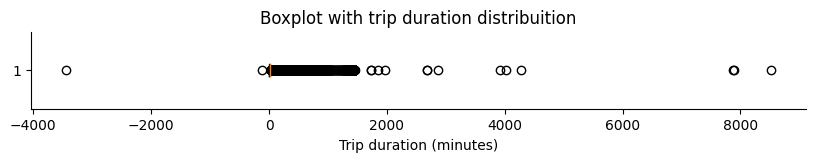

In [7]:
plt.figure(figsize=(10, 1))
plt.gca().spines[["top", "right"]].set_visible(False)
plt.boxplot(january["duration"], vert=False)
plt.xlabel("Trip duration (minutes)")
plt.title("Boxplot with trip duration distribuition")
plt.show()

In [8]:
january_no_outliers = january[(january["duration"] >= 1) & (january["duration"] <= 60)]

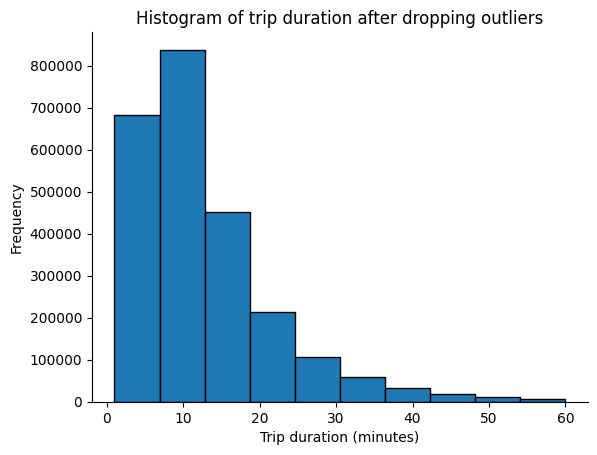

In [9]:
plt.hist(january_no_outliers["duration"], edgecolor="black")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.ylabel("Frequency")
plt.xlabel("Trip duration (minutes)")
plt.title("Histogram of trip duration after dropping outliers")
plt.show()

In [10]:
print(f"Records left after dropping outliers: {((january_no_outliers.shape[0] / january.shape[0]) * 100):.2f}%")

Records left after dropping outliers: 98.28%


## One-hot encoding

In [11]:
def one_hot_encoding(data: pd.DataFrame):
    result = data.copy()
    
    locations = ['PULocationID', 'DOLocationID']
    result[locations] = result[locations].astype(str)

    return result[locations].to_dict(orient="records")

In [12]:
train = one_hot_encoding(january_no_outliers)

dv = DictVectorizer()
X_train = dv.fit_transform(train)

print(f"Vectorizer feature matrix dimensionality: {len(dv.get_feature_names_out())}")

Vectorizer feature matrix dimensionality: 515


## Training a model

In [13]:
y_train = january_no_outliers["duration"]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

print(f"RMSE: {mean_squared_error(y_train, y_pred, squared=False):.2f}")

RMSE: 6.99


## Evaluating the model

In [14]:
february = compute_duration(february)

february_no_outliers = february[(february["duration"] >= 1) & (february["duration"] <= 60)]

val = one_hot_encoding(february_no_outliers)

X_val = dv.transform(val) # Same vectorizer used in train dataset
y_val = february_no_outliers["duration"]

y_pred = model.predict(X_val)

print(f"RMSE: {mean_squared_error(y_val, y_pred, squared=False):.2f}")

RMSE: 7.79
